### Hamiltonian decomposition method to get minimum eigenstates
Instead of summing two sets of measurement in the Position (X) and Momentum (P) bases, we break down a Hamiltonian into the linear combination of many single-qubit gate tensor products. 

At the end of the waveforming ansatz portion in each quantum circuit, append relevant gates (Pauli Y / Z / Hadamard / none ("identity matrix")) then measure. The result is weighted-summed. 

Change log at the end of file.


#### Contents
##### 1) Set global variables

##### 2) Make Hamiltonian

##### 3) Matrix functions

##### 4) Making the ansatz

##### 5) Measurement

##### 6) Cost function

##### 7) Optimization

##### 8) Show optimization results

In [243]:
# Load Qiskit libraries
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Gate
from qiskit import Aer, transpile, assemble
from qiskit.quantum_info.operators import Operator, Pauli    # for operator
from qiskit.aqua.algorithms import NumPyEigensolver
backend = Aer.get_backend("qasm_simulator")
from qiskit.aqua.components.optimizers import SPSA    # for optimization
from qiskit.visualization import plot_histogram

import numpy as np
from numpy import linalg as LA
from numpy import kron    # for matrix math
import csv
import matplotlib.pyplot as plt
%matplotlib inline  
import time


#### (1) Set global variables
Number of qubits, ansatz parameters

In [244]:
QUBIT_COUNT   = 2                      # expand for finite well
DEPTH         = 2                      # depth of ansatz
ENERGY_STATES = 3                      # to get higher states
ANSATZ_TYPE   = "H_Opt"                # choose "H_Opt" or "Ry" or "UCC"
NUM_SHOTS     = 5000                   # number of shots per quantum simulation
MAXITER       = 100   # about 1 second per iteration

In [245]:
# other general settings 
np.set_printoptions(precision=4)       # numpy print precision
np.set_printoptions(suppress=True)     # suppress scientific notation
num_states = 2**QUBIT_COUNT

####  (2) Make Hamiltonian

Now the Hamiltonian type is encoded as a function so it can be called only as needed.
The Hamiltonian must be Hermitian ( equal its conjugate transpose )

In [246]:
# test case where we input known Hamiltonian
sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)

# Momentum Hamiltonian function
def make_momentum_Hamiltonian(num_states):
    """
    Returns the momentum Hamiltonian for the corresponding num_states size
    """
    lattice = []
    leftmost = (1-n)/2    # consider lattice
    Xpos = []             # initialize position matrix

    for i in range(num_states):    # 2^QUBIT COUNT
        lattice.append(leftmost + i)
        # for position matrix    
        Xpos_row = []
        for j in range(num_states):
            Xpos_row.append(0)
        Xpos_row[i] = (leftmost + i)*np.sqrt(2*np.pi/n)
        Xpos.append(Xpos_row)
    Xpos = np.array(Xpos)

    F = np.zeros([n,n], dtype=complex)  # zero matrix 
    for j in range(num_states):
        for k in range(num_states):
            x = 1/np.sqrt(num_states)*np.e**(2*np.pi*(1j/n)*lattice[j]*lattice[k])
            F[j][k] = x

    F_dagger = np.transpose(np.conjugate(F))
    #print(F.dot(F_dagger))    # should be I, unitary operator
    FourierOperator = Operator(F)
    P = (F_dagger.dot(Xpos.dot(F)))
    Hamiltonian = P.dot(P)/2  # flat potential well model here    
    # Hamiltonian_harmonic = P.dot(P)/2 + Xpos.dot(Xpos)/2    # with harmonic
    return Hamiltonian
    

def make_other_Hamiltonian(num_states):
    """
    Make an arbitrary Hamiltonian
    """
    '''
    Hamiltonian = (-0.2427450172749822)*kron(kron(kron(id,id),sz),id)+\
                    (-0.2427450172749822)*kron(kron(kron(id,id),id),sz)+\
                    (-0.04207254303152995)*kron(kron(kron(id,id),id),id)+\
                    (0.17771358191549907)*kron(kron(kron(sz,id),id),id)+\
                    (0.17771358191549919)*kron(kron(kron(id,sz),id),id)+\
                    (0.12293330460167415)*kron(kron(kron(sz,id),sz),id)+\
                    (0.12293330460167415)*kron(kron(kron(id,sz),id),sz)+\
                    (0.16768338881432715)*kron(kron(kron(sz,id),id),sz)+\
                    (0.16768338881432715)*kron(kron(kron(id,sz),sz),id)+\
                    (0.17059759240560826)*kron(kron(kron(sz,sz),id),id)+\
                    (0.17627661476093917)*kron(kron(kron(id,id),sz),sz)+\
                    (-0.04475008421265302)*kron(kron(kron(sy,sy),sx),sx)+\
                    (-0.04475008421265302)*kron(kron(kron(sx,sx),sy),sy)+\
                    (0.04475008421265302)*kron(kron(kron(sy,sx),sx),sy)+\
                    (0.04475008421265302)*kron(kron(kron(sx,sy),sy),sx) 
    '''
    #Hamiltonian = 1*kron(id,id) + 5*kron(id,sy) + 5*kron(id,sy)
    Hamiltonian = 1*kron(kron(kron(id,id),id),id) + 5*kron(kron(kron(id,id),id),sy) - \
        2.5*kron(kron(kron(id,id),sx),id) + 3*kron(kron(kron(id,id),sx),sz) 
    # could be any sum here
       
    return Hamiltonian

def make_well_Hamiltonian(num_states):
    """
    Infinite well case. Code modified from https://math.stackexchange.com/questions/616965/finite-element-method-for-the-particle-in-a-box-problem-in-quantum-mechanics
    """
    dx = 1.0 / float(num_states - 1)   # internal parameters
    a = 1 / float(2 * dx * dx)
    hamiltonian = np.zeros((num_states, num_states))  # prepare hamiltonian matrix

    for i in range(num_states):
        for j in range(num_states):
            if i == j:
                hamiltonian[i, j] = 2 * a
            elif i == j + 1 or j == i + 1:
                hamiltonian[i, j] = -a
    return hamiltonian

Hamiltonian = make_well_Hamiltonian(num_states)
#Hamiltonian = make_other_Hamiltonian(num_states)
print("Hamiltonian chosen is:\n", Hamiltonian)
print("Check if Hermitian: H - H_dagger == 0")
print(Hamiltonian - np.transpose(np.conjugate(Hamiltonian)))

#test_H = [[ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j],\
#          [ 0.0000+0.j, -1.8302+0.j,  0.1820+0.j,  0.0000+0.j],\
#          [ 0.0000+0.j,  0.1820+0.j, -0.2738+0.j,  0.0000+0.j],\
#          [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.1824+0.j]]
# test_H = 0.981748*kron(id,id) - 0.55536*kron(sy,sy) - 0.55536*kron(id,sx)

Hamiltonian chosen is:
 [[ 9.  -4.5  0.   0. ]
 [-4.5  9.  -4.5  0. ]
 [ 0.  -4.5  9.  -4.5]
 [ 0.   0.  -4.5  9. ]]
Check if Hermitian: H - H_dagger == 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#### (3) Matrix functions
For Hamiltonian decomposition to tensor product combinations

Developed starting from:  https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html 


In [247]:
# helper functions defined from the two qubit decomposition, from michaelgoerz.net source linked
def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """
    Decompose Hermitian matrix H into linear combination of Pauli matrices
    Works for both 4x4 (2 qubits) and 16x16 (4 qubits) cases
    """
    decomp_dict = {}    # to store results
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)    # define individual Pauli operator
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    print("Tensor product decomposition of Hamiltonian:")
    
    if len(H) == 4: # 4x4 matrix for 2 qubits
        for i in range(4):
            for j in range(4):
                label = labels[i]+',' + labels[j]
                a_ij = 0.25 * HS(kron(S[i], S[j]), H)
                if abs(a_ij) >= 1E-10:
                    print("%s\t*\t( %s )" % (c2s(a_ij), label))   # save as string
                    decomp_dict[label] = float(a_ij)
                    
    elif len(H) == 16: # 16x16 matrix for 4 qubits
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    for l in range(4):
                        label = labels[i]+',' + labels[j]+','+ labels[k] +',' + labels[l] 
                        a_ij = 1/16 * HS(kron(kron(S[i], S[j]),kron(S[k], S[l])), H)
                        if abs(a_ij) >= 1E-10:
                            print("%s\t*\t( %s )" % (c2s(a_ij), label))
                            decomp_dict[label] = float(a_ij)
    print("~~~ End ~~~")
    return decomp_dict      

min_eigenvalue = np.real(min(LA.eigvals(Hamiltonian)))
print("Check if Hermitian (all real eigenvals):", LA.eigvals(Hamiltonian))
print("The expected minimum eigensvalue is", round(min_eigenvalue,6), "\n")
Hamiltonian_dict = decompose(Hamiltonian)

Check if Hermitian (all real eigenvals): [16.2812 11.7812  1.7188  6.2188]
The expected minimum eigensvalue is 1.718847 

Tensor product decomposition of Hamiltonian:
9	*	( I,I )
-4.5	*	( I,sigma_x )
-2.25	*	( sigma_x,sigma_x )
-2.25	*	( sigma_y,sigma_y )
~~~ End ~~~


<ipython-input-247-c0f85f11f4dd>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  decomp_dict[label] = float(a_ij)


#### (4) Making the ansatz

In [248]:
def subspace_select(qr, cr, qc, input_line):
    """ 
    Prepend Pauli X gate(s) to quantum circuit object based on input line
    Inputs:
        qr: QuantumRegister(QUBIT_COUNT)         
        cr: ClassicalRegister(QUBIT_COUNT)
        qc: QuantumCircuit(qr, cr)
    Output: new qr object
    Change initial state from 000 only to one of 000, 001, 010, 011, 100,
    101, 110, 111 
    Write subspace_select as a standalone function for improved readability
    """
    if input_line == 0:       # 000 in computational basis
        pass
    elif input_line == 1:     # 001
        qc.rx(np.pi, qr[0])
    elif input_line == 2:     # 010
        qc.rx(np.pi, qr[1])
    elif input_line == 3:     # 011
        qc.rx(np.pi, qr[0])
        qc.rx(np.pi, qr[1])
    elif input_line == 4:     # 100
        qc.rx(np.pi, qr[2])    
    elif input_line == 5:     # 101
        qc.rx(np.pi, qr[0])
        qc.rx(np.pi, qr[2]) 
    elif input_line == 6:     # 110
        qc.rx(np.pi, qr[1])
        qc.rx(np.pi, qr[2]) 
    elif input_line == 7:     # 111
        qc.rx(np.pi, qr[0])
        qc.rx(np.pi, qr[1])
        qc.rx(np.pi, qr[2])
    else:
        print("Error: input_line should be integer from 0 to 7")
        return
    qc.barrier()    # for clarity, after input setup
    
    return qc

In [249]:
from qiskit.circuit.library.standard_gates import U2Gate

def get_ansatz_full(params, input_line, operator_list):
    """
    operator_list from the Hamiltonian decomposition
    """
    qr = QuantumRegister(QUBIT_COUNT)         
    cr = ClassicalRegister(QUBIT_COUNT)
    qc = QuantumCircuit(qr, cr)
    
    # set input using new function  
    qc = subspace_select(qr, cr, qc, input_line)     # SSVQE activated in v2.8
    
    if ANSATZ_TYPE == "H_Opt":  # Hardware optimized ansatz
        for layer in range(DEPTH):    
            # pre-entangling section
            qc.ry(params[2*layer], qr[0])    
            qc.rz(params[2*layer + 1], qr[0])
            qc.ry(params[2*layer + 2*DEPTH + 2], qr[1])   # second wire
            qc.rz(params[2*layer + 2*DEPTH + 3], qr[1])    
            if QUBIT_COUNT >= 3:
                qc.ry(params[2*layer + 4*DEPTH + 4], qr[2])   # third wire
                qc.rz(params[2*layer + 4*DEPTH + 5], qr[2])    
            if QUBIT_COUNT >= 4:
                qc.ry(params[2*layer + 6*DEPTH + 6], qr[3])   # fourth wire     
                qc.rz(params[2*layer + 6*DEPTH + 7], qr[3])
            if QUBIT_COUNT >= 5:
                qc.ry(params[2*layer + 8*DEPTH + 8], qr[4])   # fifth wire     
                qc.rz(params[2*layer + 8*DEPTH + 9], qr[4])
            
            # entangling
            qc.cx(qr[0], qr[1])
            if QUBIT_COUNT >= 3:
                qc.cx(qr[0], qr[2])
                qc.cx(qr[1], qr[2])
            if QUBIT_COUNT >= 4:
                qc.cx(qr[0], qr[3])
                qc.cx(qr[1], qr[3])
                qc.cx(qr[2], qr[3])
            if QUBIT_COUNT >= 5:
                qc.cx(qr[0], qr[4])
                qc.cx(qr[1], qr[4])
                qc.cx(qr[2], qr[4])
                qc.cx(qr[3], qr[4])
            qc.barrier()
            '''
            qc.rzx(np.pi/2, qr[0], qr[1])    #previous entangling
            if QUBIT_COUNT >= 3:
                qc.rzx(np.pi/2, qr[1], qr[2])
            if QUBIT_COUNT >= 4:
                qc.rzx(np.pi/2, qr[2], qr[3])
            if QUBIT_COUNT >= 5:
                qc.rzx(np.pi/2, qr[3], qr[4])
            qc.barrier()
            '''
    
        qc.ry(params[2*DEPTH], qr[0])   # first wire 
        qc.rz(params[2*DEPTH+1], qr[0])
        qc.ry(params[4*DEPTH+2], qr[1])   # second wire
        qc.rz(params[4*DEPTH+3], qr[1])
        if QUBIT_COUNT >= 3:
            qc.ry(params[6*DEPTH+4], qr[2])  # third wire
            qc.rz(params[6*DEPTH+5], qr[2])    
        if QUBIT_COUNT >= 4:
            qc.ry(params[8*DEPTH+6], qr[3])   # fourth wire      
            qc.rz(params[8*DEPTH+7], qr[3])
        if QUBIT_COUNT >= 5:
            qc.ry(params[10*DEPTH+8], qr[4])   # fifth wire      
            qc.rz(params[10*DEPTH+9], qr[4])    
    
    elif ANSATZ_TYPE == "UCC":     # Two qubit UCC  https://arxiv.org/pdf/1910.14030.pdf
        qc.rx(-np.pi/2, qr[1]) 
        qc.h(qr[0]) 
        qc.cx(qr[1], qr[0])   # check order
        qc.rz(params[0], qr[0])   # single parameter
        qc.cx(qr[1], qr[0])   # check order
        qc.rx(-np.pi/2, qr[1]) 
        qc.h(qr[0])     
    
    for qubit_line in range(QUBIT_COUNT):
        if operator_list[qubit_line] == "I" or operator_list[qubit_line] == "sigma_z":
            pass
        elif operator_list[qubit_line] == "sigma_x": 
            qc.h(qubit_line)    # Hadamard gate from David Khach github tutorial
        elif operator_list[qubit_line] == "sigma_y": 
            qc.u2(0, np.pi/2, qr[qubit_line])    # use U2 Gate 
            
    qc.barrier()
    for qubit_line in range(QUBIT_COUNT):
        qc.measure(qr[qubit_line], cr[qubit_line])
    
    return qc

#test_circuit = get_ansatz_full(wild_params, 0, ['I', 'sigma_x', 'sigma_y', 'sigma_y'])
#test_circuit.draw("mpl")

In [250]:
if ANSATZ_TYPE == "H_Opt":
    PARAM_COUNT   = QUBIT_COUNT*(2*DEPTH+2)
    print("Hardware optimized ansatz chosen. (default for now)")
elif ANSATZ_TYPE == "UCC":
    PARAM_COUNT = 1
    print("UCC chosen for debugging tests.")
    
np.random.seed(1)
wild_params = np.random.rand(PARAM_COUNT)
print(len(wild_params), "random starting ansatz parameters have been generated.")


Hardware optimized ansatz chosen. (default for now)
12 random starting ansatz parameters have been generated.


#### (5) Measurement
Functions needed to get measurement of a quantum circuit

In [251]:
def decimal_to_bin(dec_number):
    """
    Decimal number is input, output as binary with zeros in front 
    e.g. 1 becomes 001 when QUBIT_COUNT=3; outputs binary as string
    """ 
    bin_number = str(bin(dec_number).replace("0b", ""))
    while len(bin_number) < QUBIT_COUNT:
        bin_number = "0" + bin_number
    return bin_number

def get_probability_distribution(counts):
    # return array of probability    
    output_distr = []    
    for result in measure_bins:    
        if counts.get(result) != None:
            output_distr.append(counts.get(result)/NUM_SHOTS)
        else:
            output_distr.append(0)    
    return output_distr

def get_output(quantum_circuit):
    """
    Measures the quantum circuit to get the probability distribution of results
    Output: get_probability_distribution array results
    backend and NUM_SHOTS are fixed
    """
    t_qc = transpile(quantum_circuit, backend)
    qobj = assemble(t_qc, shots=NUM_SHOTS)     
    result = backend.run(qobj).result()
    output_distr = get_probability_distribution(result.get_counts(quantum_circuit))
    return output_distr

measure_bins = []   
for count in range(num_states):    # where n is 2**QUBIT_COUNT
    measure_bins.append(decimal_to_bin(count))
print("List of measurement results generated as:\n", measure_bins, "\n")

print("These have the following costs:")
if QUBIT_COUNT == 4:
    costArray = [1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]    
elif QUBIT_COUNT == 2:
    costArray = [1, -1, -1, 1]
    # to assign cost for measurements from '0000' to '1111'
print(costArray)   
print("allocating |0> with +1 and |1> with -1 each")

List of measurement results generated as:
 ['00', '01', '10', '11'] 

These have the following costs:
[1, -1, -1, 1]
allocating |0> with +1 and |1> with -1 each


##### Sanity check of circuit

<ipython-input-249-159f322f01a2>:86: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  qc.u2(0, np.pi/2, qr[qubit_line])    # use U2 Gate


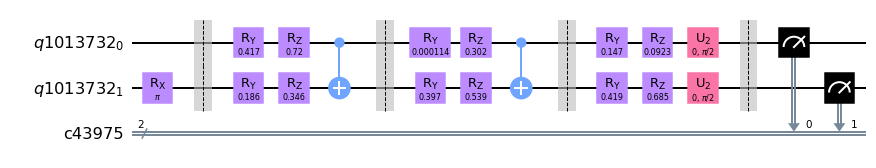

In [252]:
if QUBIT_COUNT == 2:
    qc_example = get_ansatz_full(wild_params, 2, ["sigma_y","sigma_y"])
elif QUBIT_COUNT == 3:
    qc_example = get_ansatz_full(wild_params, 3, ["I","I","sigma_x"])
elif QUBIT_COUNT == 4:
    qc_example = get_ansatz_full(wild_params, 4, ["I","I","sigma_x","sigma_x"])
qc_example.draw("mpl")

#### (6) Cost function

In [253]:
def cost_function(params):
    """
    Generates the total cost of an ansatz after measurement and weighted sum from each
    component tensor product
    Treats Hamiltonian_dict as a constant, since cost_function for use in SPSA only
    accepts params as one argument
    """
    total_cost = 0
    cost_str = ""
    for label in Hamiltonian_dict:
        if label != "I,I" and label != "I,I,I,I":
            cost = 0  # for this particular set of operators
            cost_weight = Hamiltonian_dict[label]
            label_list = label.split(',')
            component_qc = get_ansatz_full(params, 0, label_list)
            output_distr = get_output(component_qc)     # measure Hamiltonian 
            for i in range(num_states):
                cost += (costArray[i]*output_distr[i])  
            total_cost += cost*cost_weight
            cost_str += " " + str(round(cost*cost_weight,4))
        #print("Do label", label, "contribution:", cost*cost_weight)
        elif label == "I,I" or label == "I,I,I,I":
            total_cost += Hamiltonian_dict[label]
    
    with open('VQEcost_decomp.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([total_cost])      # with structure does csv file closure at end        
    #print("total_cost:", total_cost)
    print("via:", cost_str, " total:", round(total_cost,4))
    
    return total_cost

In [254]:
# added to Hamiltonian decomposition test 25 April, based on Closed Loop code
def cost_function_SSVQE(params):
    """
    Cost function for Subspace VQE search, compute sum across different line inputs
    Includes a for loop over ENERGY_STATES constant
    """
    total_cost = 0
    line_cost_str = ""   # to save energy states' values

    for line in range(ENERGY_STATES):  # line = 0,1,2  
        #print("line:", line)   # debug to ensure code runs
        weight = 3 - line   
        # compute line_cost per line (orthogonal input)
        line_cost = 0   # subcost per line
        cost_str = ""
        
        for label in Hamiltonian_dict:  
            if label != "I,I" and label != "I,I,I,I":
                cost = 0  # for this particular set of operators
                cost_weight = Hamiltonian_dict[label]
                label_list = label.split(',')
                component_qc = get_ansatz_full(params, line, label_list)  # activate line
                output_distr = get_output(component_qc)     # measure Hamiltonian 
                for i in range(num_states):
                    cost += (costArray[i]*output_distr[i])  
                line_cost += cost*cost_weight
                cost_str += " " + str(round(cost*cost_weight,4))
            elif label == "I,I" or label == "I,I,I,I":
                line_cost += Hamiltonian_dict[label]
        
        total_cost += line_cost*weight    
        line_cost_str+= str(round(line_cost,4))+" "
            
    with open('SSVQEcost_results.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([total_cost])      # with structure does csv file closure at end
    print("Via:", line_cost_str, "Total:", round(total_cost,4))
    
    return total_cost

#### (7) Optimization
Using SPSA

In [255]:
# Optimization here
print("Starting optimization -- overwrite the csv -- ")
f = open('VQEcost_decomp.csv', 'w')  # overwrite the csv
f.close()
f2 = open('SSVQEcost_results.csv', 'w')  # overwrite the csv
f2.close()

optimizer = SPSA(maxiter=MAXITER, save_steps=1, last_avg=1, c0=0.62, \
                     c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False)
print("--- SPSA Optimizer ---")

start_time = time.time()
ret = optimizer.optimize(num_vars=PARAM_COUNT, objective_function=cost_function_SSVQE,\
                         initial_point=wild_params)
end_time = time.time()
print("Optimization took:", round(end_time-start_time,4), "seconds.")
gate_params = ret[0]   

Starting optimization -- overwrite the csv -- 
--- SPSA Optimizer ---


<ipython-input-249-159f322f01a2>:86: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  qc.u2(0, np.pi/2, qr[qubit_line])    # use U2 Gate


Via: 7.7256 9.0378 10.4049  Total: 51.6573
Via: 5.7528 10.9368 11.4057  Total: 50.5377
Via: 6.8229 8.5248 10.6263  Total: 48.1446
Via: 6.9813 11.4606 10.7415  Total: 54.6066
Via: 6.5772 9.0549 11.3211  Total: 49.1625
Via: 6.8913 10.5894 10.4445  Total: 52.2972
Via: 8.0082 9.8226 10.0008  Total: 53.6706
Via: 5.7294 9.8694 11.4354  Total: 48.3624
Via: 6.3621 10.9269 11.061  Total: 52.0011
Via: 6.8733 8.9865 10.3356  Total: 48.9285
Via: 7.1937 10.1835 10.2051  Total: 52.1532
Via: 6.1029 9.6345 11.286  Total: 48.8637
Via: 5.6691 9.2691 11.6001  Total: 47.1456
Via: 7.74 10.4598 9.7362  Total: 53.8758
Via: 7.1496 9.1899 10.341  Total: 50.1696
Via: 6.6636 10.4958 11.0664  Total: 52.0488
Via: 6.7293 10.0296 11.0826  Total: 51.3297
Via: 6.6375 9.8001 10.7235  Total: 50.2362
Via: 6.6888 9.3528 10.3212  Total: 49.0932
Via: 7.0695 10.4562 11.0916  Total: 53.2125
Via: 7.2099 11.0241 10.2096  Total: 53.8875
Via: 6.381 8.9793 11.4237  Total: 48.5253
Via: 7.587 10.3221 10.2105  Total: 53.6157
Via: 6.0

Via: 2.0988 6.5799 11.1456  Total: 30.6018
Via: 2.2707 6.7491 11.0736  Total: 31.3839
Via: 2.286 6.5007 10.9242  Total: 30.7836
Via: 2.0277 6.6249 11.142  Total: 30.4749
Via: 2.0097 6.6564 11.259  Total: 30.6009
Via: 2.2509 6.4872 11.0772  Total: 30.8043
Via: 2.3076 6.5394 11.0187  Total: 31.0203
Via: 2.0178 6.5763 11.2383  Total: 30.4443
Via: 2.1204 6.5529 11.268  Total: 30.735
Via: 2.0205 6.7104 11.1375  Total: 30.6198
Via: 2.0808 6.5223 11.1861  Total: 30.4731
Via: 2.0124 6.7077 11.2338  Total: 30.6864
Via: 2.268 6.7104 10.9215  Total: 31.1463
Via: 1.9548 6.6123 11.4741  Total: 30.5631
Via: 2.2482 6.2145 11.4327  Total: 30.6063
Via: 1.9566 7.0326 11.0313  Total: 30.9663
Via: 1.8414 6.9066 11.3634  Total: 30.7008
Via: 2.2176 6.4611 11.1006  Total: 30.6756
Via: 2.1276 6.5979 11.3004  Total: 30.879
Via: 2.1501 6.3477 11.3139  Total: 30.4596
Via: 2.1276 6.7014 11.2167  Total: 31.0023
Via: 2.1159 6.3576 11.2518  Total: 30.3147
Via: 1.9638 6.3945 11.2509  Total: 29.9313
Via: 2.0133 6.7023

#### (8) Show optimization results

In [256]:
# === Display results ===
print("Optimized gate_params:",gate_params)
print("\nDoing a few more variance checks...")
final_result = []
count = []
for i in range(10):
    final_result.append(cost_function_SSVQE(gate_params))    # update here! 
    count.append(i)
print("\nFor ground state:")
print("Standard deviation:", round(np.std(final_result),6))
print("Average           :", round(np.mean(final_result),6))
print("Expecting         :", round(min_eigenvalue,6))
#plt.plot(count, final_result, ".")

Optimized gate_params: [ 1.7663 -0.0143 -0.2437  0.6353  0.3711 -0.6199 -0.8911  0.541   1.3695
  0.5399  0.7411 -0.0738]

Doing a few more variance checks...


<ipython-input-249-159f322f01a2>:86: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  qc.u2(0, np.pi/2, qr[qubit_line])    # use U2 Gate


Via: 1.9296 6.4413 11.349  Total: 30.0204
Via: 1.9125 6.5367 11.4822  Total: 30.2931
Via: 2.0088 6.4737 11.3958  Total: 30.3696
Via: 1.9359 6.4962 11.3814  Total: 30.1815
Via: 1.899 6.4008 11.3526  Total: 29.8512
Via: 1.9035 6.489 11.3058  Total: 29.9943
Via: 1.9152 6.4233 11.4444  Total: 30.0366
Via: 1.8819 6.4314 11.3409  Total: 29.8494
Via: 1.8558 6.5142 11.3769  Total: 29.9727
Via: 1.9458 6.4251 11.4174  Total: 30.105

For ground state:
Standard deviation: 0.163839
Average           : 30.06738
Expecting         : 1.718847


##### Plot cost function trajectory

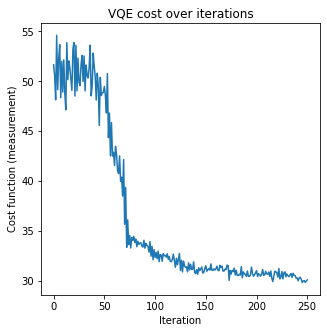

In [257]:
# displaying optimizer convergence trajectory
VQE_cost = []    # list for jupyter
iteration = []

with open('SSVQEcost_results.csv') as f:    # Update here too if VQE/SSVQE
    reader = csv.reader(f)
    count = 0
    for row in reader:
        if row != []:     # some rows appear as [] on Windows
            #print(row)
            VQE_cost.append(float(row[0]))
            iteration.append(count)
            count += 1

# plot VQE cost trajectory
plt.figure(figsize=(5,5))   # bigger size
plt.plot(iteration, VQE_cost)
plt.ylabel('Cost function (measurement)')
plt.xlabel('Iteration')
plt.title('VQE cost over iterations')

start_cost = '{0:.4f}'.format(VQE_cost[0])
end_cost = '{0:.4f}'.format(VQE_cost[-1])

##### Plot actual state

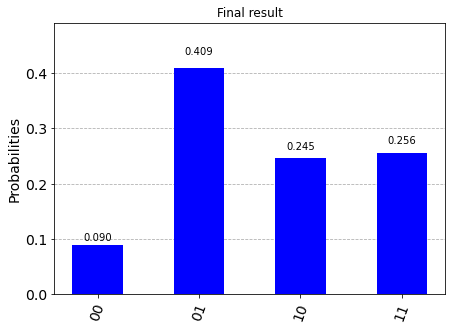

In [258]:
from qiskit.visualization import plot_histogram
qc1 = get_ansatz_full(gate_params, 0, ['I','I','I','I'])
t_qc = transpile(qc1, backend)
qobj = assemble(t_qc, shots=NUM_SHOTS)     
counts = backend.run(qobj).result().get_counts(qc1)
output_distr = get_probability_distribution(counts)
plot_histogram(counts, color='blue', title="Final result")

In [259]:
"""
Code references:
 https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html 
 https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis
 https://www.mustythoughts.com/variational-quantum-eigensolver-explained
 https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb

Change log:
 v2.1 With the standard quantum measurement cost function, of +1 for |0> and -1 for |1> in result string. 
      The cost function does not stablize and keeps decreasing. 
 v2.2 Bugs in the decomposition step, 1/16 factor fixed
      The measurement should use +/-1 eigenvalue method, NOT the position space formulation.
 v2.3 Cleaned up some formating. Simple four-qubit Hamiltonians verified - numpy result matches VQE
      Compute identity matrix contribution separately
 v2.4 Tried with the finite difference matrix (https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Computational_Physics_(Chong)/08%3A_Sparse_Matrices/8.04%3A_Example-_Particle-in-a-Box_Problem)
 v2.5 Compare against test results from: https://joshuagoings.com/2020/08/20/VQE/
      Implement UCC as shown in https://arxiv.org/pdf/1910.14030.pdf 
      Consistent value of -1.14 found
 v2.6 Improved readability
 v2.7 Two qubit works for ground state. Copied over the weighted SSVQE cost function to reach excited states.  
"""
print("~~End of code~~")

~~End of code~~
